In [70]:
# Traffic Signal Recognition using Modified LeNet-5 Architecture

In [50]:
!pip install tensorflow==1.15
!pip install keras
!pip install opencv-python

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import random
import csv
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import random
import numpy as np
from sklearn.utils import shuffle
import os
from os import listdir
from skimage.io import imread

In [51]:
#Loading the data

training_data = r"C:\Users\samhi\OneDrive\Desktop\AIProject\train.p"
validation_data = r"C:\Users\samhi\OneDrive\Desktop\AIProject\valid.p"
testing_data = r"C:\Users\samhi\OneDrive\Desktop\AIProject\test.p"
global traffic_signs
with open(training_data, mode='rb') as file:
    train_data = pickle.load(file)
with open(validation_data, mode='rb') as file:
    valid_data = pickle.load(file)
with open(testing_data, mode='rb') as file:
    test_data = pickle.load(file)
    
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

with open(r"C:\Users\samhi\OneDrive\Desktop\AIProject\signnames.csv", newline='') as csvfile:
    signs = csv.reader(csvfile, delimiter=',')
    
    traffic_signs=[]
    for sign in signs:
        traffic_signs.append(sign[1])

traffic_signs.pop(0)

'SignName'

In [52]:
#Visualizing and exploring data

class visualizing:
    
    def dataset_information(X_train, X_valid, X_test, y_train):
        no_of_training = X_train.shape[0]
        no_of_validation = X_valid.shape[0]
        no_of_test = X_test.shape[0]
        image_size = X_train[0].shape
        no_of_classes = max(y_train)+1

        print("Number of imanges in training set =", no_of_training)
        print("Number of images in validation set =", no_of_validation)
        print("Number of images in test set =", no_of_test)
        print("Shape of the input image =", image_size)
        print("Number of classes in the dataset =", no_of_classes)
    
    def frequency_visualization(X_train, y_train, X_valid, y_valid, X_test, y_test):
        fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)
        no_of_classes = int(max(y_train)+1)
        print("Frequency histograms for training, validation and test datasets\n")

        titles=['Training Dataset','Validation Dataset','Test Dataset']
        classes = no_of_classes
        no_of_images = 5

        n0, bins0, patches=ax0.hist(y_train, classes, facecolor='g', alpha=0.65)
        ax0.set_title(titles[0])
        ax0.set_ylabel('Frequency')

        n1, bins1, patches=ax1.hist(y_valid, classes, facecolor='b', alpha=0.65)
        ax1.set_title(titles[1])
        ax1.set_xlabel('Labels')

        n2, bins2, patches=ax2.hist(y_test, classes, facecolor='r', alpha=0.65)
        ax2.set_title(titles[2])

        fig.tight_layout()
        plt.show()

        sort_n0 = np.argsort(n0,axis=-1)
        sort_n1 = np.argsort(n1,axis=-1)
        sort_n2 = np.argsort(n2,axis=-1)

        maximum_freqclass=[]
        maximum_freqclass=[sort_n0[no_of_classes-no_of_images:]]
        maximum_freqclass=np.append(maximum_freqclass,[sort_n1[no_of_classes-no_of_images:]],axis=0)
        maximum_freqclass=np.append(maximum_freqclass,[sort_n2[no_of_classes-no_of_images:]],axis=0)

        print("Images from the dataset\n")

        for i,j in enumerate(maximum_freqclass):
            fig, ax = plt.subplots(ncols=no_of_images, figsize=(15, 4))
            fig.tight_layout()
            for k in range(no_of_images):
                value = j[no_of_images-(1+k)]
                max_index = np.max(np.where(y_valid == value))
                image = X_valid[max_index].squeeze()
                ax[k].imshow(image, cmap = "gray")
                ax[k].set_title('Label: '+ str(y_valid[max_index]))
                ax[k].axis('off')
            fig.suptitle(titles[i])

In [53]:
#Data preprocessing

class preprocessing:
    
    #RGB to Gray conversion
    def RGBtoGray(RGBimage):
        image_shape = RGBimage.shape[0]
        gray_image=np.zeros((image_shape ,32,32,1))
        for i in range(image_shape):
            tmp = cv2.cvtColor(RGBimage[i], cv2.COLOR_RGB2GRAY)
            gray_image[i]= np.reshape(tmp,(32,32,1))
    
        return gray_image
    
    #Data augmentation
    def data_augmentation(gray_image,data_labels):
        image_shape = gray_image.shape[0]
        frequency = np.zeros(no_of_classes)
        for i in range(no_of_classes):
            no_of_instances = np.sum(data_labels==i)
            frequency[i] = no_of_instances/image_shape
    
        n_aug = int(1.0 * image_shape)
        aug_X = np.array(np.zeros((n_aug,32,32,1)))
        aug_y = np.array(np.zeros((n_aug)))
        for i in range(n_aug):
            index = random.randint(0, image_shape - 1)
            aug_X[i] = gray_image[index]
            aug_y[i] = data_labels[index]
            trigger = random.uniform(1/np.max(frequency),1/np.min(frequency))
            while frequency[int(aug_y[i])]*trigger>1.05: 
                index = random.randint(0, image_shape - 1)
                aug_X[i] = gray_image[index]
                aug_y[i] = data_labels[index]
                no_of_instances = np.sum(data_labels == aug_y[i])
                trigger = random.uniform(1/np.max(frequency),1/np.min(frequency))

        for i in range(n_aug):
            n = random.randint(2,4)
            rot = random.randint(-20, 20)
            M = cv2.getRotationMatrix2D((32/n,32/n),rot,1)
            tmp = cv2.warpAffine(aug_X[i],M,(32,32))
        
            noise = 10 * np.random.random((32, 32))
            tmp = tmp + noise
            aug_X[i] = np.reshape(tmp,(32,32,1))
    
        return aug_X, aug_y
    
    #Data Normalization
    def normalize_data(gray_image):
        return (gray_image-128)/128


In [54]:
#Loading web images

class webimages:
    
    def new_dataset():
        dir = "C:/Users/samhi/OneDrive/Desktop/AIProject/web_images/"
        images_list = listdir(dir)
        dataset = []
        labels = []
        for i in images_list:
            tmp = os.path.splitext(os.path.basename(i))[0]
            labels.append(int(tmp[0:2]))
            img = imread(dir + i)
            img = cv2.resize(img, (32, 32))
            img = cv2.GaussianBlur(img,(3,3),0)
            dataset.append(img)

        return np.asarray(dataset), np.asarray(labels)
    
    def frequency_visualization_web(ind, no_of_images):
        dir = "C:/Users/samhi/OneDrive/Desktop/AIProject/web_images/"
        images_list = listdir(dir)
        dataset = []
        labels = []
        for i in images_list:
            tmp = os.path.splitext(os.path.basename(i))[0]
            labels.append(int(tmp[0:2]))
            img = imread(dir + i)
            img = cv2.resize(img, (32, 32))
            dataset.append(img)
        
        new_data = np.asarray(dataset)
        new_labels = np.asarray(labels)
    
        try_data = new_data[ind]
        try_labels = new_labels[ind]

        fig, ax = plt.subplots(ncols=no_of_images, figsize=(15, 5))
        fig.tight_layout()
        for k in range(no_of_images):
            img = try_data[k].squeeze()
            ax[k].imshow(img, cmap="gray")
            ax[k].set_title('Label: '+ str(try_labels[k]))
            ax[k].axis('off')
            
    #Accuracy on web images
    def get_accuracy_webimages(new_data, new_labels):
        no_of_examples = len(new_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        batch_x = new_data
        batch_y = new_labels
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / no_of_examples * 100

In [55]:
visualizing.dataset_information(X_train, X_valid, X_test, y_train)

Number of imanges in training set = 34799
Number of images in validation set = 4410
Number of images in test set = 12630
Shape of the input image = (32, 32, 3)
Number of classes in the dataset = 43


Frequency histograms for training, validation and test datasets



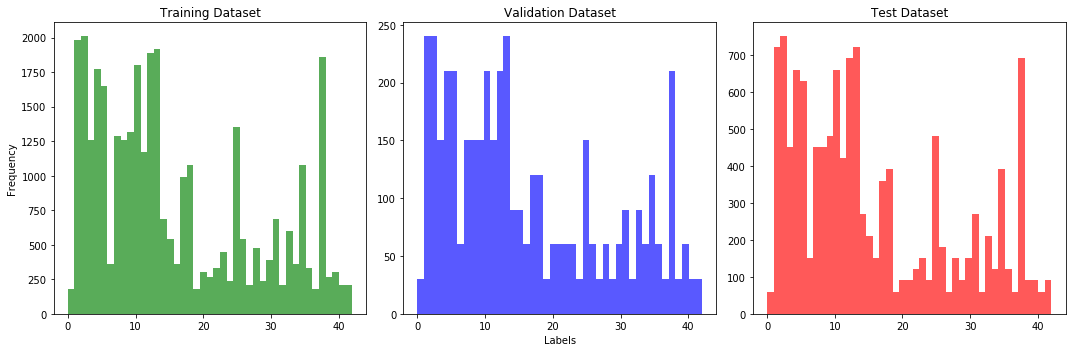

Images from the dataset



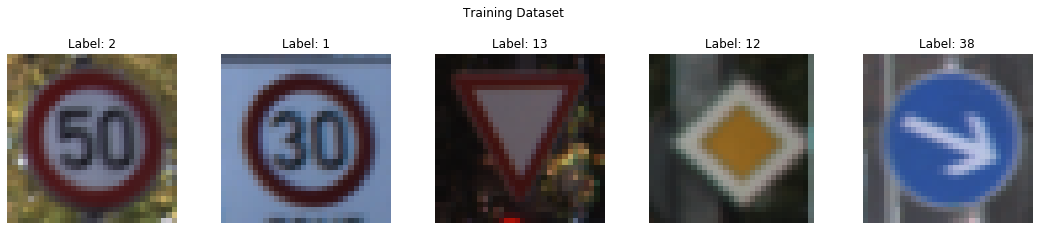

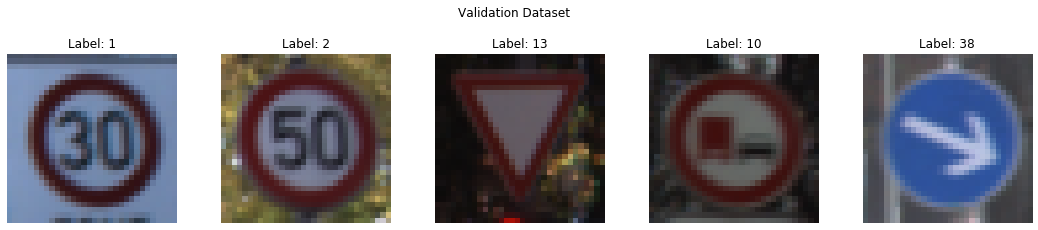

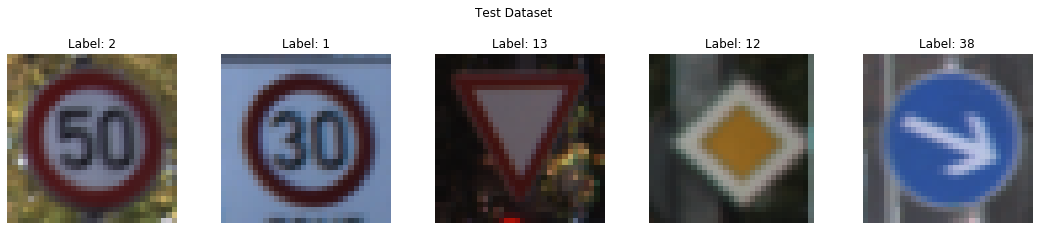

In [56]:
visualizing.frequency_visualization(X_train, y_train, X_valid, y_valid, X_test, y_test)

Number of images in augemented training dataset =  69598 

Frequency histograms for training, validation and test datasets



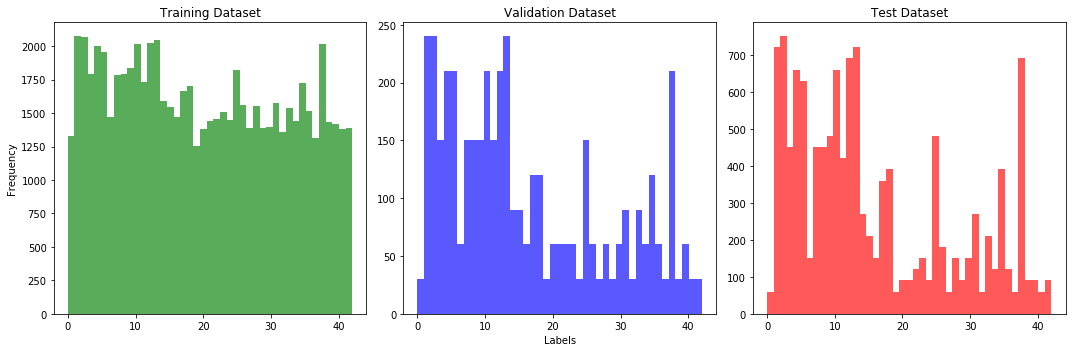

Images from the dataset



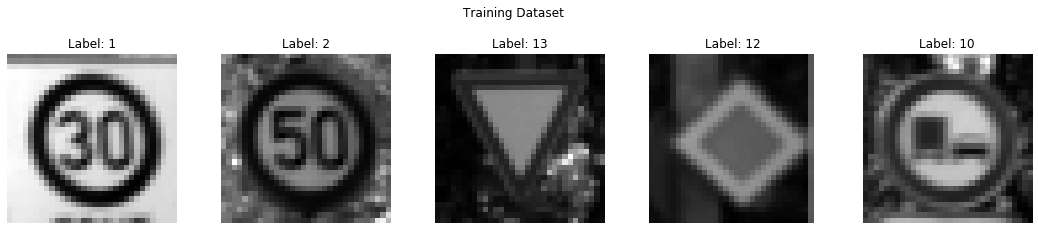

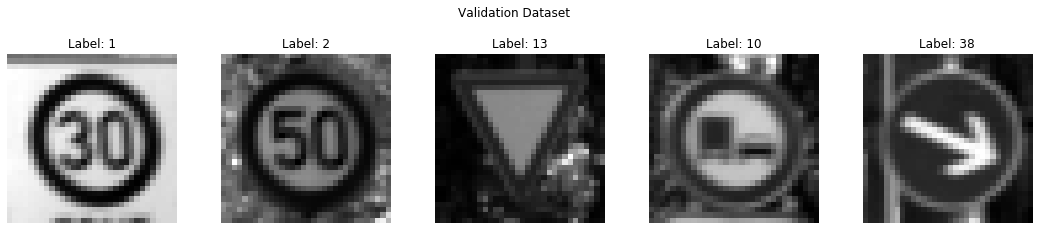

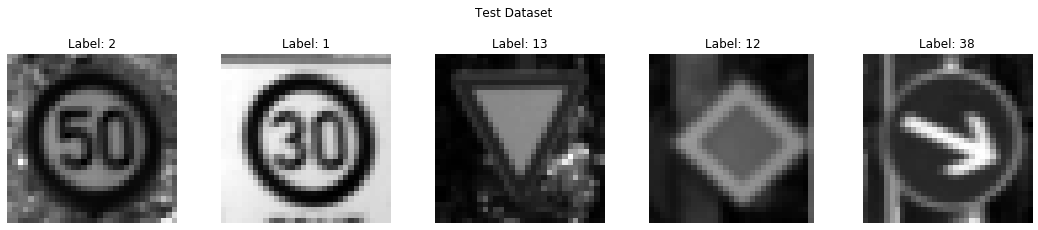

In [57]:
#Performing data preprocessing

no_of_classes = int(max(y_train)+1)

X_train, y_train = shuffle(X_train, y_train)

nX_train = preprocessing.RGBtoGray(X_train)
nX_valid = preprocessing.RGBtoGray(X_valid)
nX_test = preprocessing.RGBtoGray(X_test)

aug_X, aug_y = preprocessing.data_augmentation(nX_train, y_train)
nX_train = np.concatenate((nX_train,aug_X))
y_train = np.concatenate((y_train,aug_y))

print("Number of images in augemented training dataset = ", nX_train.shape[0], "\n")

nX_train = preprocessing.normalize_data(nX_train)
nX_valid = preprocessing.normalize_data(nX_valid)
nX_test = preprocessing.normalize_data(nX_test)

visualizing.frequency_visualization(nX_train, y_train, nX_valid, y_valid, nX_test, y_test)


In [58]:
#Modified LeNet-5 architecture

class modifiedModel:
    
    #Defining parameters
    global EPOCHS, BATCH_SIZE, weights, biases,saver
    EPOCHS = 25
    BATCH_SIZE = 128
    mu = 0
    sigma = 0.05
    weights = [
        tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma),name="w_conv1"),
        tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 80), mean=mu, stddev=sigma),name="w_conv2"),
        tf.Variable(tf.truncated_normal(shape=(3, 3, 80, 30), mean=mu, stddev=sigma),name="w_conv3"),
        tf.Variable(tf.truncated_normal(shape=(1080,750), mean=mu, stddev=sigma),name="w_fconn1"),
        tf.Variable(tf.truncated_normal(shape=(750, 350), mean=mu, stddev=sigma),name="w_fconn2"),
        tf.Variable(tf.truncated_normal(shape=(350, no_of_classes), mean=mu, stddev=sigma),name="w_out")]

    biases= [
        tf.Variable(tf.zeros([16]),name="b_conv1"),
        tf.Variable(tf.zeros([80]),name="b_conv2"),
        tf.Variable(tf.zeros([30]),name="b_conv3"),
        tf.Variable(tf.zeros([750]),name="b_fconn1"),
        tf.Variable(tf.zeros([350]),name="b_fconn2"),
        tf.Variable(tf.zeros([no_of_classes]),name="b_out")]

    saver = tf.train.Saver()
    
    #Building the model
    def modifiedLeNet(x, keep_prob):   
        global conv1, conv2, conv3
        
        stride=[1,1,1,1]
    
        #Convolutional layer 1
        conv1=tf.nn.bias_add(tf.nn.conv2d(x, weights[0], stride, padding='SAME'), biases[0])
        #ReLu activation function
        conv1=tf.nn.relu(conv1)
        #Max pooling layer 1
        conv1=tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
        
        #Convolutional layer 2
        conv2=tf.nn.bias_add(tf.nn.conv2d(conv1, weights[1], stride, padding='VALID'), biases[1])
        #ReLu activation function
        conv2=tf.nn.relu(conv2)
        #Max pooling layer 2
        conv2=tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
    
        #Convolutional layer 3
        conv3=tf.nn.bias_add(tf.nn.conv2d(conv2, weights[2], stride, padding='VALID'), biases[2])
        #ReLu activation function
        conv3=tf.nn.relu(conv3)
        #Max pooling layer 3
        conv3=tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        #Flattening the output
        flat = flatten(conv3)
    
        #Fully Connected Layer 1
        fconn1 = tf.add(tf.matmul(flat, weights[3]), biases[3])
        #Drop out
        fconn1 = tf.nn.dropout(fconn1,keep_prob)

        #Fully Connected Layer 2
        fconn2 = tf.add(tf.matmul(fconn1, weights[4]), biases[4])
        #Drop out
        fconn2 = tf.nn.dropout(fconn2,keep_prob)

        logits= tf.add(tf.matmul(fconn2, weights[5]), biases[5])
    
        return logits
    

In [59]:
#Performance Evaluation

class evaluation:
    
    global x, y, one_hot_y, training_operation, accuracy_operation, correct_prediction, keep_prob, logits, cross_entropy, loss_operation, optimizer 
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, no_of_classes)
    keep_prob = tf.placeholder(tf.float32)
    logits = modifiedModel.modifiedLeNet(x, keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def get_accuracy(X_data, y_data):
        no_of_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, no_of_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / no_of_examples

    def evaluate_performance(X_data, y_data, BATCH_SIZE=1):
        no_of_examples=len(X_data)
        tp = np.zeros(no_of_classes)
        fp = np.zeros(no_of_classes)
        fn = np.zeros(no_of_classes)

        for offset in range(0, no_of_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            pred = sess.run(tf.argmax(logits, 1), feed_dict = {x: batch_x, keep_prob: 1})
            real = batch_y
            out = sess.run(tf.equal(pred, real))
            for i in range(len(out)):  
                if out[i]:
                    tp[pred[i]] += 1
                else:
                    fp[pred[i]] += 1
                    fn[real[i]] += 1
    
        precision = [tp[i]/(tp[i]+fp[i]) if tp[i]!=0 else 0 for i in range(len(tp))]
        recall = [tp[i]/(tp[i]+fn[i]) if tp[i]!=0 else 0 for i in range(len(tp))]
        return precision, recall


In [60]:
#Training the model

class training:
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        no_of_examples = len(X_train)
    
        print("Training...\n")
        for i in range(EPOCHS):
            nX_train, y_train = shuffle(nX_train, y_train)
            for offset in range(0, no_of_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = nX_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.35})

            training_accuracy = evaluation.get_accuracy(nX_train, y_train)
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.2f}%".format(training_accuracy*100))
        
            validation_accuracy = evaluation.get_accuracy(nX_valid, y_valid)
            print("Validation Accuracy = {:.2f}%".format(validation_accuracy*100))
            print("\n")
        
        saver.save(sess, "./modifiedLeNet")
        print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 86.39%
Validation Accuracy = 84.76%


EPOCH 2 ...
Training Accuracy = 95.14%
Validation Accuracy = 92.24%


EPOCH 3 ...
Training Accuracy = 97.03%
Validation Accuracy = 95.33%


EPOCH 4 ...
Training Accuracy = 97.62%
Validation Accuracy = 95.31%


EPOCH 5 ...
Training Accuracy = 98.49%
Validation Accuracy = 95.92%


EPOCH 6 ...
Training Accuracy = 98.46%
Validation Accuracy = 95.26%


EPOCH 7 ...
Training Accuracy = 98.71%
Validation Accuracy = 96.24%


EPOCH 8 ...
Training Accuracy = 98.80%
Validation Accuracy = 96.10%


EPOCH 9 ...
Training Accuracy = 98.95%
Validation Accuracy = 97.05%


EPOCH 10 ...
Training Accuracy = 99.00%
Validation Accuracy = 96.37%


EPOCH 11 ...
Training Accuracy = 99.26%
Validation Accuracy = 97.37%


EPOCH 12 ...
Training Accuracy = 99.14%
Validation Accuracy = 96.19%


EPOCH 13 ...
Training Accuracy = 99.24%
Validation Accuracy = 96.96%


EPOCH 14 ...
Training Accuracy = 98.90%
Validation Accuracy = 97.57%


EP

INFO:tensorflow:Restoring parameters from ./modifiedLeNet
Test Accuracy = 95.67%




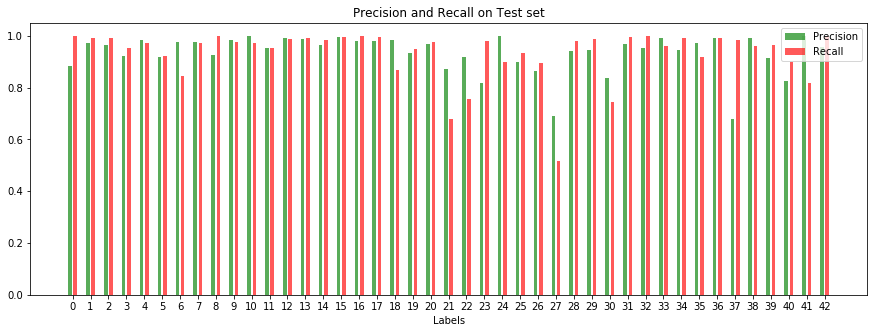

In [61]:
#Testing the model

with tf.Session() as sess:
    saver.restore(sess, "./modifiedLeNet")
    test_accuracy = evaluation.get_accuracy(nX_test, y_test)    
    test_precision, test_recall = evaluation.evaluate_performance(nX_test, y_test, BATCH_SIZE)

print("Test Accuracy = {:.2f}%".format(test_accuracy*100))
print("\n")
labels = np.asarray([1.*i for i in range(no_of_classes)])
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
l1 = ax.bar(labels-0.15, test_precision, width=0.2, facecolor='g', alpha=0.65)
l2 = ax.bar(labels+0.15, test_recall, width=0.2, facecolor='r', alpha=0.65)
ax.set_title('Precision and Recall on Test set')
ax.set_xlabel('Labels')
ax.set_xticks(range(no_of_classes))
plt.legend([l1, l2],["Precision", "Recall"]);

In [62]:
#Loading web images

new_data, new_labels = webimages.new_dataset()
new_data = preprocessing.RGBtoGray(new_data)
new_data = preprocessing.normalize_data(new_data)

print("Number of web images = ",new_data.shape[0],"\n")
print("Labels of the web images: \n")
for i in new_labels:
    print("Label:",i," ", traffic_signs[i])

Number of web images =  30 

Labels of the web images: 

Label: 0   Speed limit (20km/h)
Label: 0   Speed limit (20km/h)
Label: 0   Speed limit (20km/h)
Label: 1   Speed limit (30km/h)
Label: 1   Speed limit (30km/h)
Label: 1   Speed limit (30km/h)
Label: 3   Speed limit (60km/h)
Label: 6   End of speed limit (80km/h)
Label: 9   No passing
Label: 11   Right-of-way at the next intersection
Label: 13   Yield
Label: 14   Stop
Label: 14   Stop
Label: 17   No entry
Label: 18   General caution
Label: 22   Bumpy road
Label: 22   Bumpy road
Label: 23   Slippery road
Label: 24   Road narrows on the right
Label: 25   Road work
Label: 25   Road work
Label: 25   Road work
Label: 25   Road work
Label: 27   Pedestrians
Label: 28   Children crossing
Label: 28   Children crossing
Label: 33   Turn right ahead
Label: 35   Ahead only
Label: 36   Go straight or right
Label: 37   Go straight or left


Few images from the downloaded web images dataset


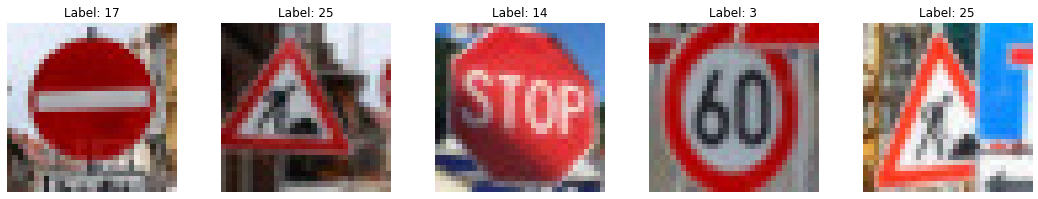

In [63]:
#Exploring web images

no_of_examples = 5 
rand_index = np.random.randint(0,new_data.shape[0]-1,(5))
try_data = new_data[rand_index]
try_labels = new_labels[rand_index]

print("Few images from the downloaded web images dataset")
webimages.frequency_visualization_web(rand_index,no_of_examples)

In [64]:
#Softmax probabilites for examples in web images

take_top_softmax = 5
with tf.Session() as sess:
    saver.restore(sess, "./modifiedLeNet")
    softmax = sess.run(tf.nn.softmax(logits), feed_dict = {x:try_data, keep_prob:1})
    maximum_softmax=sess.run(tf.nn.top_k(softmax, k = take_top_softmax))
    
prediction = maximum_softmax[1]

print("\nPredicted traffic signs:\n")
for i in prediction[:,0]:
    print("Label:",i," ", traffic_signs[i])    

INFO:tensorflow:Restoring parameters from ./modifiedLeNet

Predicted traffic signs:

Label: 17   No entry
Label: 25   Road work
Label: 38   Keep right
Label: 3   Speed limit (60km/h)
Label: 25   Road work


In [65]:
#Accuracy on web images and choosen images

with tf.Session() as sess:
    saver.restore(sess, "./modifiedLeNet")
    accuracy = webimages.get_accuracy_webimages(new_data, new_labels)
    print("Accuracy with web images data set = {:.2f}%".format(accuracy))
    accuracy = webimages.get_accuracy_webimages(try_data, try_labels)
    print("Accuracy with chosen images from web images = {:.2f}%".format(accuracy))
    web_precision, web_recall = evaluation.evaluate_performance(new_data, new_labels)

INFO:tensorflow:Restoring parameters from ./modifiedLeNet
Accuracy with web images data set = 80.00%
Accuracy with chosen images from web images = 80.00%


INFO:tensorflow:Restoring parameters from ./modifiedLeNet


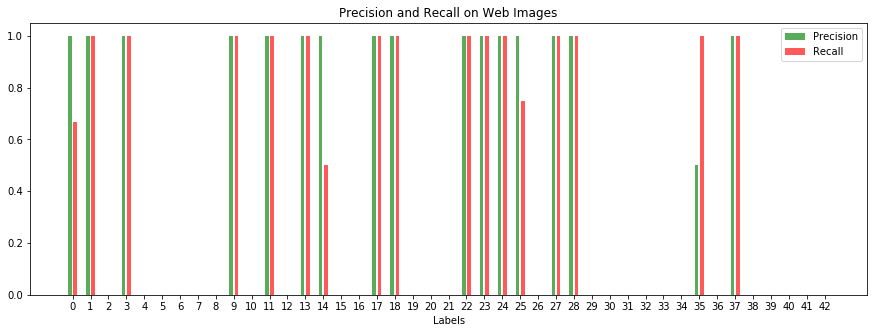

In [66]:
#Precision and recall on web images

with tf.Session() as sess:
    saver.restore(sess, "./modifiedLeNet")
    web_precision, web_recall = evaluation.evaluate_performance(new_data, new_labels)

labels = np.asarray([1. * i for i in range(no_of_classes)])
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1,1,1)
l1 = ax.bar(labels-0.15, web_precision, width=0.2, facecolor='g', alpha=0.65)
l2 = ax.bar(labels+0.15, web_recall, width=0.2, facecolor='r', alpha=0.65)
ax.set_title('Precision and Recall on Web Images')
ax.set_xlabel('Labels')
ax.set_xticks(range(no_of_classes))
plt.legend([l1, l2],["Precision", "Recall"]);

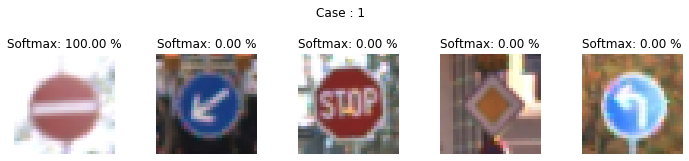

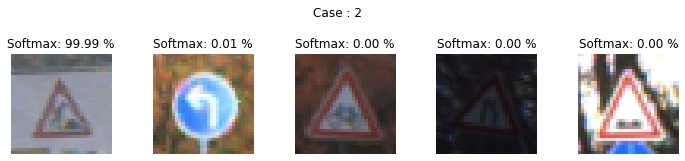

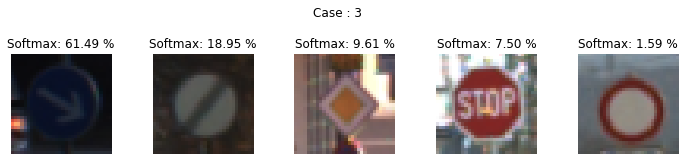

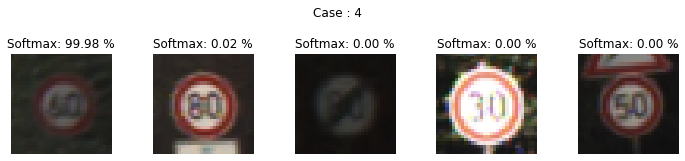

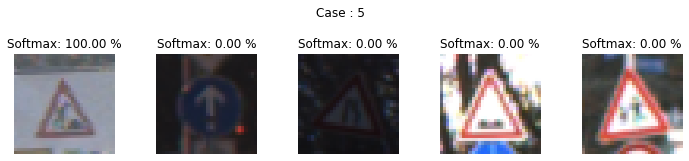

In [69]:
#Softmax Probabilites of images from web

for j in range(no_of_examples):
    fig, ax = plt.subplots(ncols=take_top_softmax, figsize=(10, 3))
    fig.tight_layout()
    for k in range(take_top_softmax):
        ind = np.where(y_valid == prediction[j,k])
        image = X_valid[ind[0][10]].squeeze()
        ax[k].imshow(image, cmap="gray")
        ax[k].set_title('Softmax: {:.2f} %'.format(maximum_softmax[0][j,k]*100))
        ax[k].set_xlabel('Label: '+ str(prediction[j,k]))
        ax[k].axis('off')
    fig.suptitle('Case : '+str(j+1))